# Churn model

## Which metrics are the most important as indicators of churn? 

The most important key metrics would be Customer Retention rate & Customer Churn rate:
________

<b>Customer Retention Rate</b>
(Total # of Customers at end of period - New acquired Customers) / Customers at start of period

Customers at end of period = 600   
New customers acquired = 100  
Customers at start of period = 1000  

<b>(600 - 100) / 1000 = 50% </b>
____________________
<b>Customer Churn</b>

Annual Churn Rate = (Number of Customers at Start of Year - Number of Customers at End of Year) / Number of Customers at Start of Year

Start of year = 1000
End of year = 500

<b> (1000-500) / 1000 = 50% </b>
________
<b> Abandonment rate </b>
Example of abandonment rate at a call center

Call abandonment rate (%): (Number of calls received - Number of calls handled) / Number of calls received

Receive 1000 succesful calls, 250 abandonded in < 5 secs, 750 succesfully handled:

((1000 - 750) / 1000) x 100 = 25%

# Data Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as prof
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import auc, f1_score

%matplotlib inline
np.random.seed(123)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data prep & cleaning

In [3]:
# Import the data
data = pd.read_csv('data.csv')

In [4]:
# Lowercase column names
data.columns = data.columns.str.lower()

In [5]:
# Overall information about data
# No null values
# Mixture of Categorical and Numerical
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            7043 non-null   object 
 1   hasuserchurned    7043 non-null   object 
 2   totalcharges      7043 non-null   object 
 3   monthlycharges    7043 non-null   float64
 4   contracttype      7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   gender            7043 non-null   object 
 7   ageover30         7043 non-null   int64  
 8   ismarried         7043 non-null   object 
 9   haschildren       7043 non-null   object 
 10  monthstenure      7043 non-null   int64  
 11  hasphoneline      7043 non-null   object 
 12  hasmultiplelines  7043 non-null   object 
 13  internetservice   7043 non-null   object 
 14  onlinesecurity    7043 non-null   object 
 15  onlinebackup      7043 non-null   object 
 16  deviceprotection  7043 non-null   object 


In [6]:
# How many unique values per variable
data.nunique()

userid              7043
hasuserchurned         2
totalcharges        6531
monthlycharges      1585
contracttype           3
paymentmethod          4
gender                 2
ageover30              2
ismarried              2
haschildren            2
monthstenure          73
hasphoneline           2
hasmultiplelines       3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
dtype: int64

In [7]:
# Convert the target predictor variable into a numerical
data['target'] = data['hasuserchurned']
data.drop('hasuserchurned', axis=1, inplace=True)

In [8]:
# Pandas profiling report
profile = prof.ProfileReport(data, title="Dataset Profiling Report", explorative=True)

In [9]:
profile.to_notebook_iframe();

In [10]:
# Remove userid as this is a unique value
data.drop('userid', axis=1, inplace=True)

## Binary variables

In [11]:
columns = data.columns
binary_cols = []

In [12]:
# Find all binary columns in the dataset
for col in columns:
    if data[col].value_counts().shape[0] == 2:
        binary_cols.append(col)

In [13]:
binary_cols

['gender', 'ageover30', 'ismarried', 'haschildren', 'hasphoneline', 'target']

In [14]:
# Convert target variable to binary 1:0
churn_numeric = {'Yes':1, 'No':0}
data.target.replace(churn_numeric, inplace=True)

In [15]:
# Remove target
binary_cols.remove('target')

In [16]:
# Shows the average churn rate for binary variables
for col in binary_cols:
    print('Average churn rate for: ', col)
    data[[col, 'target']].groupby([col]).mean()
    print('-----------------------------------')

Average churn rate for:  gender


,target
gender,
Female,0.269209
Male,0.261603


-----------------------------------
Average churn rate for:  ageover30


,target
ageover30,
0,0.236062
1,0.416813


-----------------------------------
Average churn rate for:  ismarried


,target
ismarried,
No,0.329580
Yes,0.196649


-----------------------------------
Average churn rate for:  haschildren


,target
haschildren,
No,0.312791
Yes,0.154502


-----------------------------------
Average churn rate for:  hasphoneline


,target
hasphoneline,
No,0.249267
Yes,0.267096


-----------------------------------


In [17]:
remaining_columns = [col for col in data if col not in binary_cols]

In [18]:
data[remaining_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   totalcharges      7043 non-null   object 
 1   monthlycharges    7043 non-null   float64
 2   contracttype      7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthstenure      7043 non-null   int64  
 5   hasmultiplelines  7043 non-null   object 
 6   internetservice   7043 non-null   object 
 7   onlinesecurity    7043 non-null   object 
 8   onlinebackup      7043 non-null   object 
 9   deviceprotection  7043 non-null   object 
 10  techsupport       7043 non-null   object 
 11  streamingtv       7043 non-null   object 
 12  streamingmovies   7043 non-null   object 
 13  target            7043 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 770.5+ KB


In [19]:
data[remaining_columns].nunique()

totalcharges        6531
monthlycharges      1585
contracttype           3
paymentmethod          4
monthstenure          73
hasmultiplelines       3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
target                 2
dtype: int64

## Continous variables

In [20]:
number_variables = ['monthlycharges', 'monthstenure', 'totalcharges']

In [21]:
# Totalcharges has been incorrectly classified as a string because of some missing values
data['totalcharges'].value_counts()

           11
20.2       11
19.75       9
20.05       8
19.9        8
           ..
6638.35     1
51.15       1
223.6       1
4590.35     1
1396.25     1
Name: totalcharges, Length: 6531, dtype: int64

In [22]:
# Change blank values to nulls
data.loc[data['totalcharges'] == ' ', 'totalcharges'] = np.nan

In [23]:
# More robust to outliers (1.5 * interquartile range from inner/outer quartile)
# When the data is skewed, it is good to consider using the median value for replacing the missing values.
median_total_charges = data['totalcharges'].median()
data['totalcharges'].fillna(median_total_charges, inplace=True)

In [24]:
data['totalcharges'] = data['totalcharges'].astype(float)

In [25]:
data.describe()

,totalcharges,monthlycharges,ageover30,monthstenure,target
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2281.916928,64.761692,0.162147,32.371149,0.265370
std,2265.270398,30.090047,0.368612,24.559481,0.441561
min,18.800000,18.250000,0.000000,0.000000,0.000000
25%,402.225000,35.500000,0.000000,9.000000,0.000000
50%,1397.475000,70.350000,0.000000,29.000000,0.000000
75%,3786.600000,89.850000,0.000000,55.000000,1.000000
max,8684.800000,118.750000,1.000000,72.000000,1.000000


<Figure size 1080x576 with 0 Axes>

/Users/aidonblong/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monthlycharges'>

Text(0.5, 1.0, 'Histogram of monthlycharges')

Text(0.5, 0, 'Number of monthlycharges')

Text(0, 0.5, 'Total')

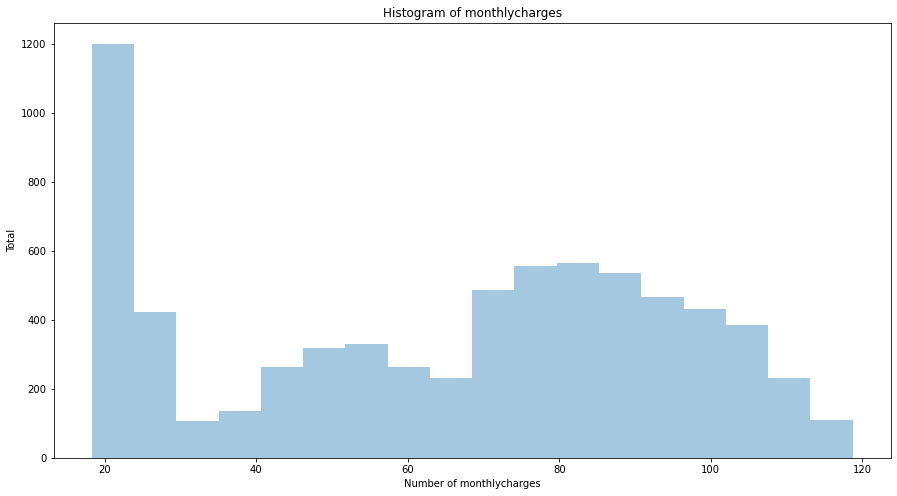

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='monthstenure'>

Text(0.5, 1.0, 'Histogram of monthstenure')

Text(0.5, 0, 'Number of monthstenure')

Text(0, 0.5, 'Total')

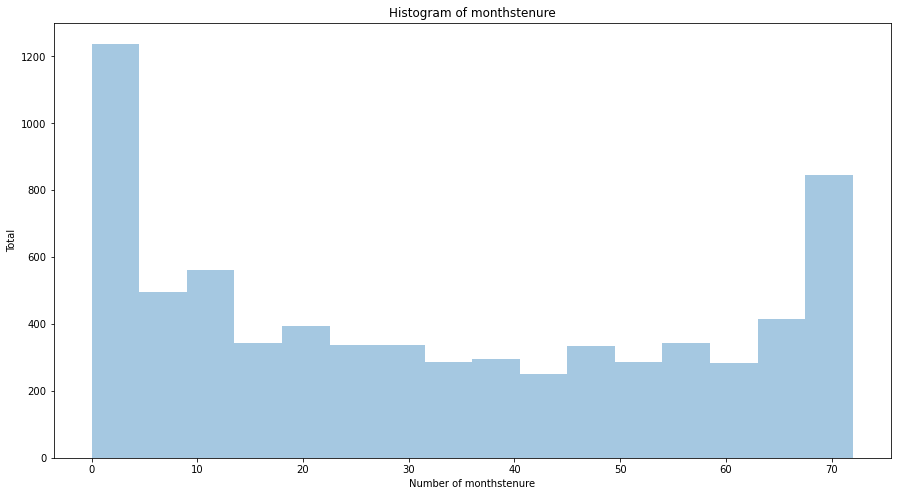

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='totalcharges'>

Text(0.5, 1.0, 'Histogram of totalcharges')

Text(0.5, 0, 'Number of totalcharges')

Text(0, 0.5, 'Total')

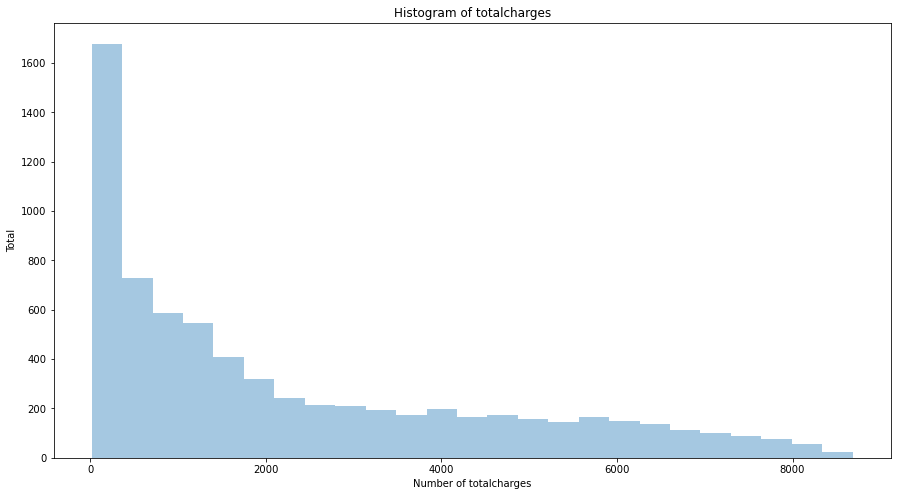

In [26]:
for var in number_variables:
    plt.figure(figsize=(15,8));
    sns.distplot(data[var], hist=True, kde=False);
    plt.title('Histogram of ' + str(var))
    plt.xlabel('Number of ' + str(var))
    plt.ylabel('Total')
    plt.show();

## Apply transformation for categorical

In [27]:
remaining_categorical_variables = ['contracttype', 
                                   'paymentmethod', 
                                   'hasmultiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']

In [28]:
# Label encoder can be used to transform categorical variables into 1,0
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

In [29]:
# OneHotEncoding of the remaining categorical variables to transform into binary format
data = pd.get_dummies(data, columns=remaining_categorical_variables)

In [30]:
data.head()

,totalcharges,monthlycharges,gender,ageover30,ismarried,haschildren,monthstenure,hasphoneline,target,contracttype_Month-to-month,contracttype_One year,contracttype_Two year,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,hasmultiplelines_No,hasmultiplelines_No phone service,hasmultiplelines_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,onlinesecurity_No,onlinesecurity_No internet service,onlinesecurity_Yes,onlinebackup_No,onlinebackup_No internet service,onlinebackup_Yes,deviceprotection_No,deviceprotection_No internet service,deviceprotection_Yes,techsupport_No,techsupport_No internet service,techsupport_Yes,streamingtv_No,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No,streamingmovies_No internet service,streamingmovies_Yes
0,1537.90,84.30,1,0,0,0,18,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0
1,50.15,50.15,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,7862.25,116.25,1,1,1,1,66,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
3,5824.75,80.85,0,0,1,1,72,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1
4,3094.65,65.65,0,0,1,0,48,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   totalcharges                             7043 non-null   float64
 1   monthlycharges                           7043 non-null   float64
 2   gender                                   7043 non-null   int64  
 3   ageover30                                7043 non-null   int64  
 4   ismarried                                7043 non-null   int64  
 5   haschildren                              7043 non-null   int64  
 6   monthstenure                             7043 non-null   int64  
 7   hasphoneline                             7043 non-null   int64  
 8   target                                   7043 non-null   int64  
 9   contracttype_Month-to-month              7043 non-null   uint8  
 10  contracttype_One year                    7043 no

In [32]:
# Create a correlation matrix on original data
correlation_matrix = data.corr()

A large positive value (near to 1.0) indicates a strong positive correlation, i.e., if the value of one of the variables increases, the value of the other variable increases as well.  
A large negative value (near to -1.0) indicates a strong negative correlation, i.e., the value of one variable decreases with the other’s increasing and vice-versa.  
A value near to 0 (both positive or negative) indicates the absence of any correlation between the two variables, and hence those variables are independent of each other.  
  
Pearson Correlation coefficient (interval scale, units of degrees etc) is one of the most used correlations, measuring the linear relationship between two continous variables.  
Spearman Correlation measures the monotonic relationship (strictly increase or decrease) between two variables

In [33]:
# Check for any correlations between target feature and 
correlation_matrix['target'].sort_values(ascending=True)

monthstenure                              -0.352229
contracttype_Two year                     -0.302253
streamingtv_No internet service           -0.227890
techsupport_No internet service           -0.227890
deviceprotection_No internet service      -0.227890
onlinebackup_No internet service          -0.227890
onlinesecurity_No internet service        -0.227890
internetservice_No                        -0.227890
streamingmovies_No internet service       -0.227890
totalcharges                              -0.199037
contracttype_One year                     -0.177820
onlinesecurity_Yes                        -0.171226
techsupport_Yes                           -0.164674
haschildren                               -0.164221
ismarried                                 -0.150448
paymentmethod_Credit card (automatic)     -0.134302
internetservice_DSL                       -0.124214
paymentmethod_Bank transfer (automatic)   -0.117937
paymentmethod_Mailed check                -0.091683
onlinebackup

# Modelling prep

In [34]:
# Dataset is unbalanced, as we have less target class
data['target'].value_counts(), data['target'].value_counts(normalize=True)

(0    5174
 1    1869
 Name: target, dtype: int64,
 0    0.73463
 1    0.26537
 Name: target, dtype: float64)

In [35]:
# Important to create balanced dataset, so as not to overcompensate on the minority calss and provide an inaccurate representation
X_0 = data[data.target == 0]
X_1 = data[data.target == 1]

In [36]:
# Create random samples for positive class
X_1_upsampled = X_1.sample(n=len(X_0), replace=True, random_state=123)
print(len(X_1_upsampled))

5174


In [37]:
X_upsampled = X_0.append(X_1_upsampled).reset_index(drop=True)

In [38]:
# Dataset is no longer unbalanced
X_upsampled['target'].value_counts(), X_upsampled['target'].value_counts(normalize=True)

(1    5174
 0    5174
 Name: target, dtype: int64,
 1    0.5
 0    0.5
 Name: target, dtype: float64)

In [39]:
# List of features
X = X_upsampled.drop('target', axis=1)

# Target
y = X_upsampled['target']

In [40]:
# Split the dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
# Scale features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance.  
Unit variance means dividing all the values by the standard deviation.  

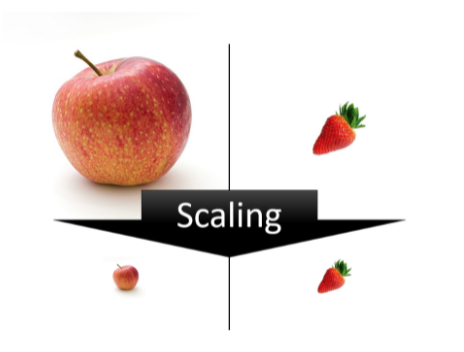

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
# 5 selected classifiers
lr = LogisticRegression()
dt = DecisionTreeClassifier() # Weak learner
rf = RandomForestClassifier() # Bootstrapped aggregation of weak learners
xgb = XGBClassifier() # Boosted learning
svc = SVC()

In [44]:
lr.fit(X_train, y_train);
dt.fit(X_train, y_train);
rf.fit(X_train, y_train);
xgb.fit(X_train, y_train);
svc.fit(X_train, y_train);

/Users/aidonblong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:08:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 1: Cross-validated check on models

Advantages: 
- Reduces overfitting as we split the dataset into multiple folds, and train the algorithm on different folds (only on large datasets it works best)
- Hyperparameter tuning to help find the optimal parameters we can feed to the model  

Disadvantages:  
- Increased amount of training time  
- Computationaly expensive  

In [45]:
from sklearn.model_selection import cross_val_score, KFold

In [46]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [47]:
print('Cross-validated 5-kfold training estimates of Accuracy')
print('Logistic Regression Accuracy: ', np.mean(cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)))
print('Decision Tree Accuracy: ', np.mean(cross_val_score(dt, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)))
print('Random Forest Accuracy: ', np.mean(cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)))
print('XGBoost Accuracy: ', np.mean(cross_val_score(xgb, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)))
print('Support Vector Accuracy: ', np.mean(cross_val_score(svc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)))

Cross-validated 5-kfold training estimates of Accuracy
Logistic Regression Accuracy:  0.7598215293313242
Decision Tree Accuracy:  0.8452513757874682
Random Forest Accuracy:  0.8791384815554864
XGBoost Accuracy:  0.8479554039073027
Support Vector Accuracy:  0.7737374785085069


## 2: AUC Performance

AUC is made up from ROC (Receiving Operating Characteristic) which is able to vizualise a tradeoff in performance.  
Specifically between True Positive Rate (TPR - Those who you correctly predicted positive) and False Positive Rate (FPR - Those who you falsly predicted positive).  
- AUC Should not be used when the dataset is heavily imbalanced, but we performed some oversampling earlier on  
- False positives for highly imbalanced datasets are pulled down due to large number of true negatives
- Use AUC when you care equally about positive and negative classes  


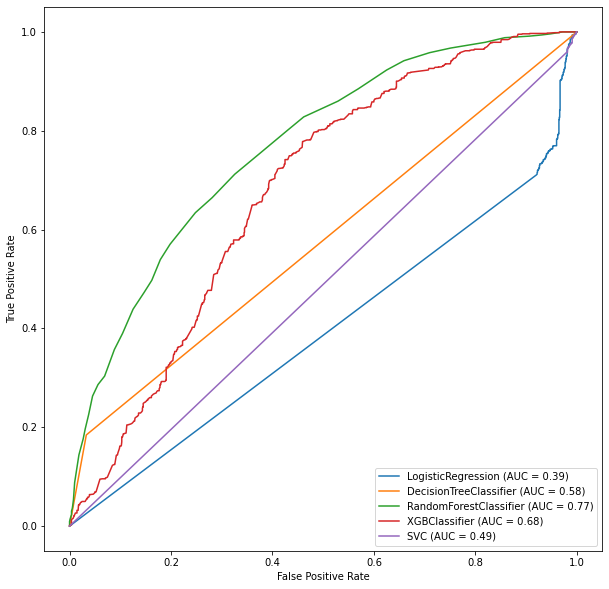

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(lr, X_test, y_test, ax=ax)
plot_roc_curve(dt, X_test, y_test, ax=ax)
plot_roc_curve(rf, X_test, y_test, ax=ax)
plot_roc_curve(xgb, X_test, y_test, ax=ax)
plot_roc_curve(svc, X_test, y_test, ax=ax);

## 3: Final Precision/Recall summary on best performing models

<b>Precision</b>: Correct positive predictions relative to total positive predictions.  
This is calculated as:  
Precision = True Positives (a customer that has churned) / (True Positives + False Positives (predicted churn, but they didn't))  
  
<b>Recall</b>: Correct positive predictions relative to total actual positives  
This is calculated as:  
Recall = True Positives ((a customer that has churned) / (True Positives + False Negatives (predicted no churn, but they did))  

<b>F1 Score</b>: Calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are rates).   
This is calculated as:  
F1 Score =  2 x Precision x Recall / Precision + Recall


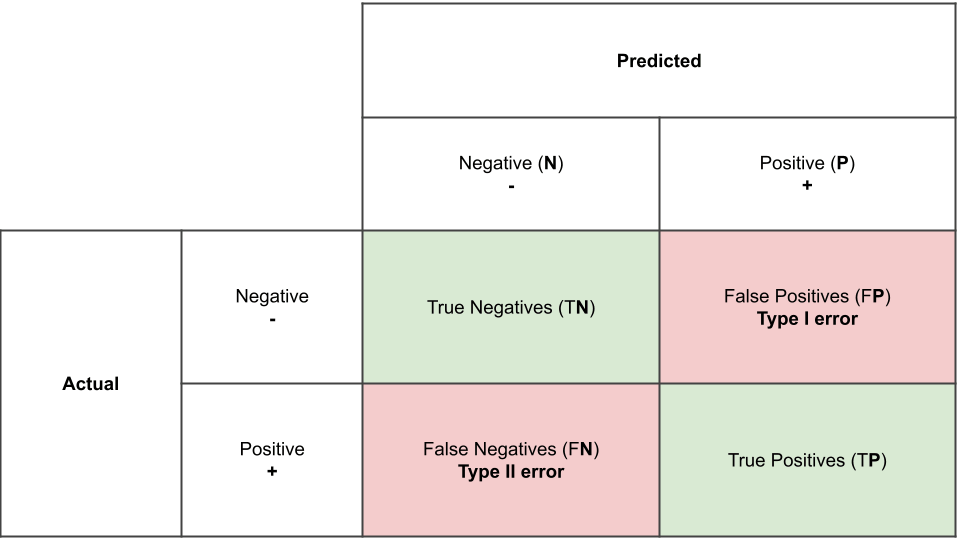  

If we were to focus on one error - the False Negative category, those customers who did actually churn but we predicted they wouldn't would be most important.

No business context in this domain, as we don't want to specifically decrease either False Negative, or False Positive and we want to ensure they are both as low as possible: F-Score will provide this.

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1302
           1       0.82      0.92      0.87      1285

    accuracy                           0.86      2587
   macro avg       0.87      0.86      0.86      2587
weighted avg       0.87      0.86      0.86      2587



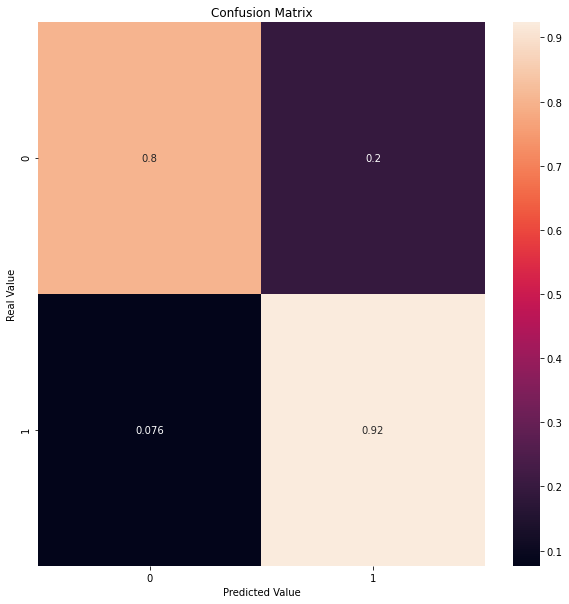

In [49]:
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('Real Value')
ax.set_xlabel('Predicted Value')

plt.show();

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1302
           1       0.86      0.95      0.90      1285

    accuracy                           0.90      2587
   macro avg       0.90      0.90      0.90      2587
weighted avg       0.90      0.90      0.90      2587



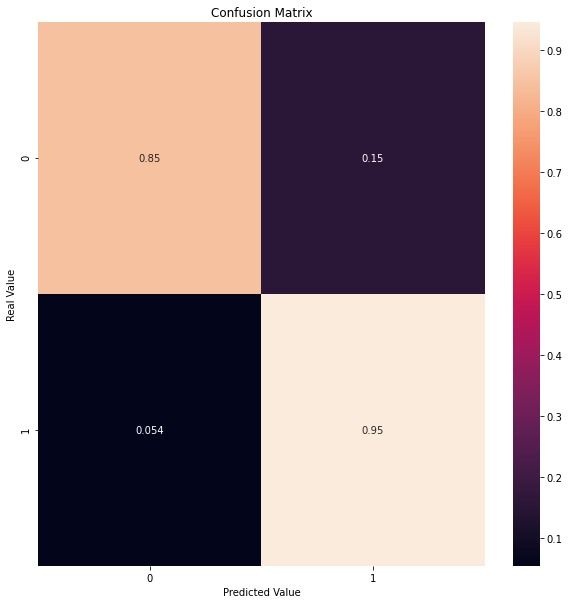

In [50]:
X_test_rf = scaler.transform(X_test)
y_pred_rf = rf.predict(X_test_rf)

# classification report
print(classification_report(y_test, y_pred_rf))

# confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_rf, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('Real Value')
ax.set_xlabel('Predicted Value')

plt.show();

## Most important features

In [51]:
features = X_test.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

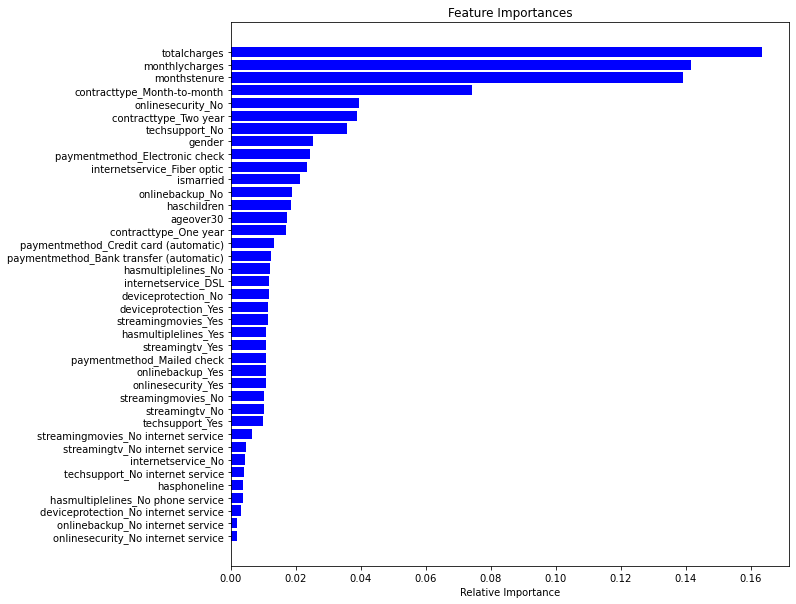

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

# Likelihood of churning on best performing model

## Which users that are currently active (not yet churned) are most at risk of churning?

In [54]:
X_test_rf = scaler.transform(X_test)
y_pred_proba_rf = rf.predict_proba(X_test_rf)

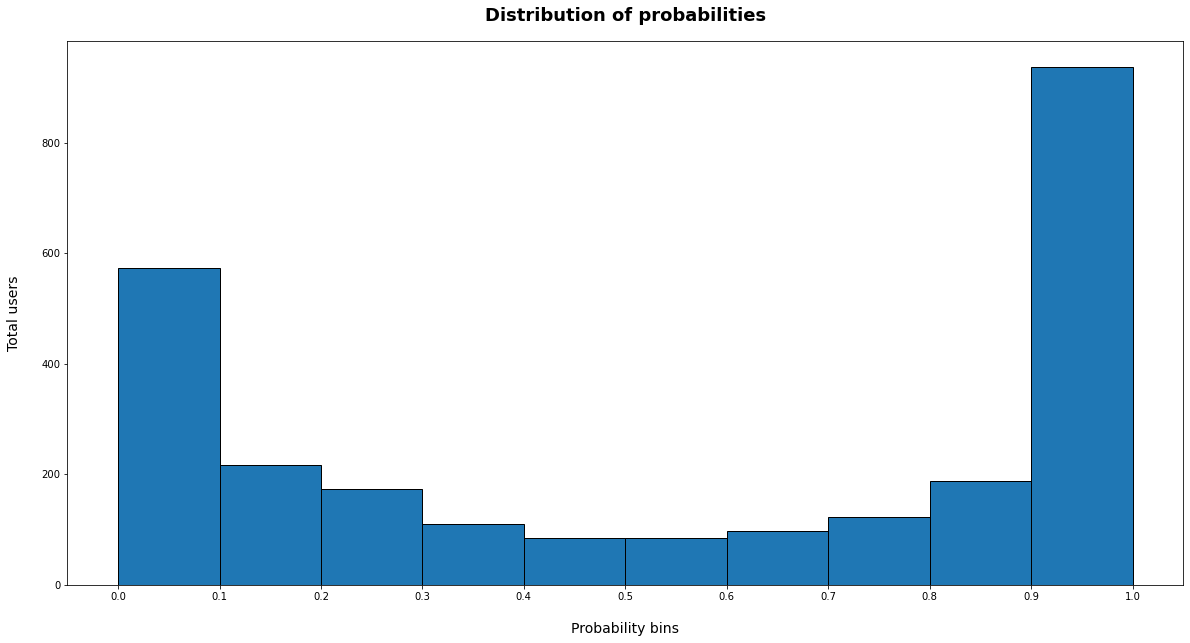

In [56]:
bins= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.figure(figsize=(20,10))
plt.title('Distribution of probabilities', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Probability bins', fontsize=14, labelpad=20)
plt.ylabel('Total users', fontsize=14, labelpad=20)
plt.hist(y_pred_proba_rf[:,1], bins=bins, edgecolor="k")
plt.xticks(bins);

The above graph shows the probability of churn distribution on the testing dataset, looking at deciles.  
You can use the segmented bins of customers to identify those that are most likely to churn, and target these first.  
A big advantage of this is to attribute marketing spend to try to retain those who are most likely to churn, and not waste it on those who are not likely to churn.  

## What commercial changes can be made to improve customer churn going forwards?

## Talk to the customers
- Be agile by talking to customers and responding to feedback  
- Allow customers an easy way to provide feedback (i.e. on Nav bar)
- Customer satisfaction surveys to determine what you are doing correclty and what you need to improve on  
- Different venues of engagement (E-mail, website, social media, chat, blog)
- Intermittent emailing, careful not to overload and to remain relevant

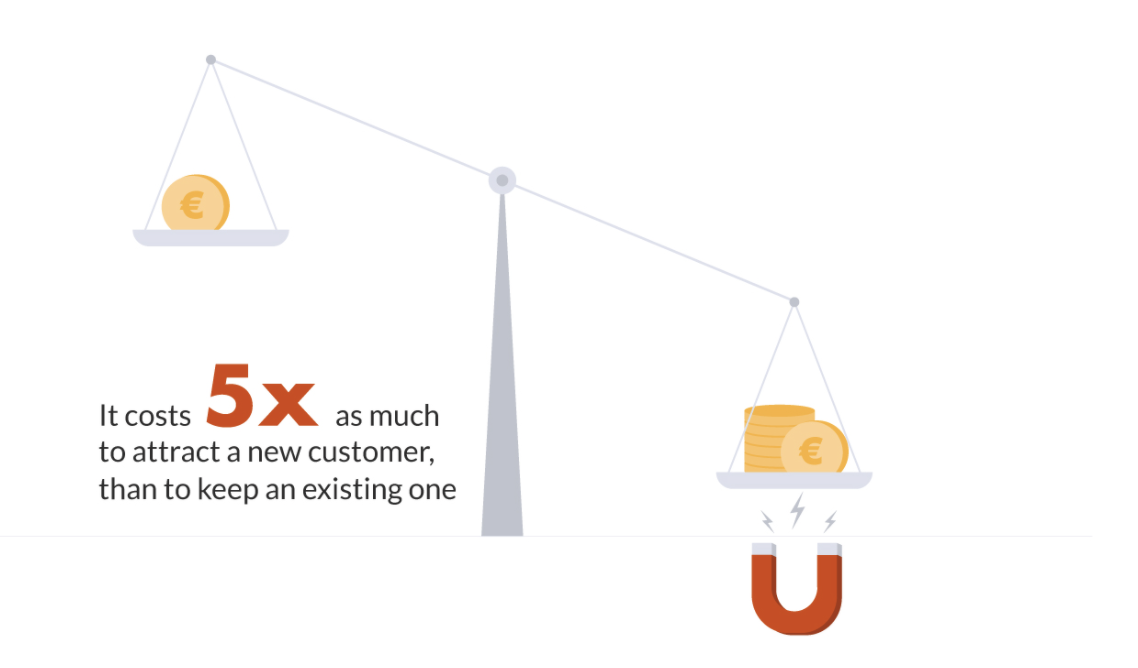

## Know what your weakness is
- Any detrimental defects that are already known, or are received from talking to customers  
- Allow time and resource to fix issues and let customers know  
- If a competitor does it better, what's to stop your customer from leaving you

## Knowing why customers cancel services
- Tieing in with the previous statements, if you figure out why customers cancel, then you can address these concerns  


## Educate the customer
- Providing a great product is fantastic
- Educating the consumer on the benefits and features of your product will increase retention and allow consumers to benefit

## Offer incentives
- Marketing campaigns offering special discounts and options for those customers who are likely to lapse  
- Offering the ability to freeze a potential subscription or service
- Offer bundles or special deals to at-risk customers

## Once again, focus on the customer
- Invest in customer service training and staff management
- Ensure the best customer service representatives deal with those consumers who wish to cancel services

# Appendix

Some extra modelling enhancements that were not neccessarily required, as the model had good enough performance already.

## Important features

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import auc, f1_score

In [59]:
rf2 = RandomForestClassifier(random_state=42)
rfcv = RFECV(estimator=rf2, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfcv .fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=42), scoring='accuracy')

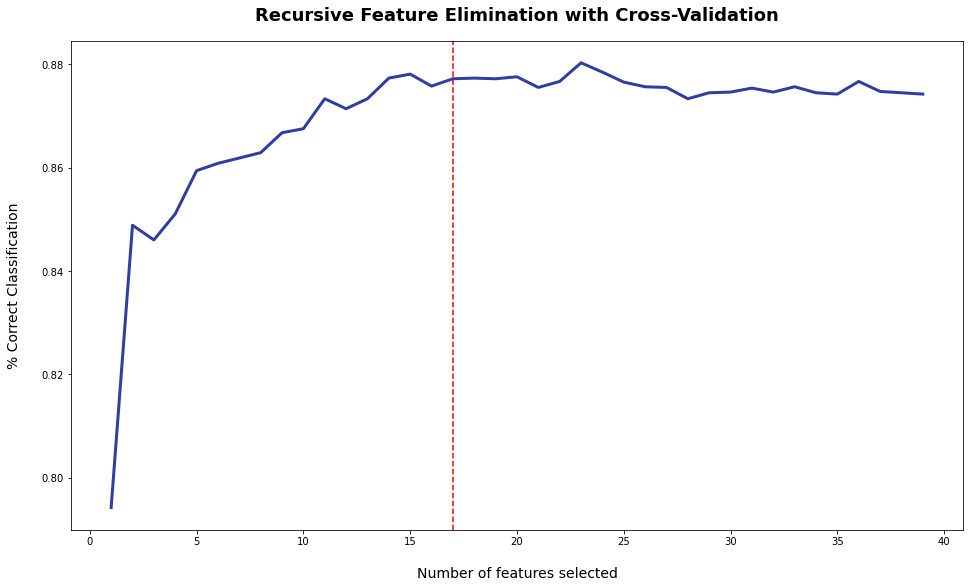

In [60]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.axvline(x=17, color='red', ls='--')
plt.plot(range(1, len(rfcv.grid_scores_) + 1), rfcv.grid_scores_, color='#303F9F', linewidth=3)
plt.show();